In [3]:
#https://rpubs.com/jhofman/nycmaps
!pip install google-cloud-core
!pip install google-cloud-bigquery
!pip install virtualenv
!pip install datalab
 

In [4]:
!pip install --upgrade google-cloud-bigquery[bqstorage,pandas]
!pip install tabulate

Requirement already up-to-date: google-cloud-bigquery[bqstorage,pandas] in c:\tools\anaconda3\lib\site-packages (1.22.0)


In [5]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "c:\\Users\\antho\\OneDrive\\Documents\\googleKey\\CS-816-2a2543d787f2.json"

In [6]:
from google.cloud import bigquery
import google.cloud.bigquery.magics

from time import sleep

import pandas as pd
import numpy as np

import io, os, pickle, math

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
bq_query_noaa  = """
    SELECT  
        ghcn.id,
        ghcn.value,
        ghcn.element,
        EXTRACT(YEAR FROM ghcn.date) as year,
        EXTRACT(MONTH FROM ghcn.date) as month,
        EXTRACT(DAY FROM ghcn.date) as day,
        EXTRACT(DAYOFWEEK FROM ghcn.date) as dow,
        ghcn.date,
        ghcn.time,  
        station.name
    FROM 
    (
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2019` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2018` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2017` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2016` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2015` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2014` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2013` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2012` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
    ) as ghcn
    JOIN
        `bigquery-public-data.ghcn_d.ghcnd_stations` station
    ON
        ghcn.id=station.id
    WHERE 
        station.latitude <= 40.940
        AND station.longitude <= -73.717
        and station.state='NY'
"""

bq_query_nypd = """
    SELECT
      reason,
      year,
      hour,
      month,
      day,
      dow,
      count(*) incidents
    FROM
        (SELECT 
            contributing_factor_vehicle_1 as reason,
            EXTRACT(YEAR FROM timestamp) as year,
            EXTRACT(MONTH FROM timestamp) as month,
            EXTRACT(HOUR FROM timestamp) as hour,
            EXTRACT(DAY FROM timestamp) as day,
            EXTRACT(DAYOFWEEK FROM timestamp) as dow
          FROM 
            `bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions`
          WHERE
            contributing_factor_vehicle_1 NOT IN ("","Unspecified")) q
    GROUP BY
      reason,
      year,
      hour,
      month,
      day,
      dow
"""

bq_query_nypd_2 = """
    SELECT
        hour,
        dow,
        sum(1) incidents,
        count(distinct date) as days
    FROM
        (SELECT 
            CAST(timestamp as DATE) as date,
            EXTRACT(HOUR FROM timestamp) as hour,
            EXTRACT(DAYOFWEEK FROM timestamp) as dow,
            1 as cnt
          FROM 
            `bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions`
          WHERE
            contributing_factor_vehicle_1 NOT IN ("","Unspecified")
            AND EXTRACT(YEAR FROM timestamp)<=2015
            ) q
    GROUP BY
        hour, 
        dow

"""
        
def get_data(query):
    client = bigquery.Client()
    dataframe = (
        client.query(query)
        .result()
        .to_dataframe()
    )
    print(dataframe.head())
    return dataframe

In [8]:
results_nypd = get_data(bq_query_nypd)

                                 reason  year  hour  month  day  dow  \
0      Using On Board Navigation Device  2018    17      1   11    5   
1                 Accelerator Defective  2017    16     10   14    7   
2  Reaction to Other Uninvolved Vehicle  2014    22      8    2    7   
3                Other Lighting Defects  2018    19     10   10    4   
4                      Steering Failure  2018     4      2    2    6   

   incidents  
0          1  
1          1  
2          1  
3          1  
4          1  


In [9]:
results_nypd.head(10)
results_nypd.shape

(486248, 7)

In [10]:
results_nypd2 = get_data(bq_query_nypd_2)
results_nypd2.head(10)

   hour  dow  incidents  days
0    18    2       3297   183
1     8    3       3447   183
2     9    2       3217   183
3    20    5       2296   183
4    15    6       3485   182


,hour,dow,incidents,days
0,18,2,3297,183
1,8,3,3447,183
2,9,2,3217,183
3,20,5,2296,183
4,15,6,3485,182
5,18,6,3424,182
6,17,2,3725,183
7,12,5,2795,183
8,20,6,2458,182
9,15,7,2595,182


In [11]:
results_noaa = get_data(bq_query_noaa)

            id  value element  year  month  day  dow        date  time  \
0  US1NYQN0026  216.0    PRCP  2018      3    8    5  2018-03-08  None   
1  US1NYQN0026   46.0    PRCP  2018      4   26    5  2018-04-26  None   
2  US1NYQN0026    0.0    PRCP  2018      3   12    2  2018-03-12  None   
3  US1NYQN0026    0.0    PRCP  2018      3   15    5  2018-03-15  None   
4  US1NYQN0026    0.0    PRCP  2018      7    9    2  2018-07-09  None   

                             name  
0  JACKSON HEIGHTS 0.3 WSW         
1  JACKSON HEIGHTS 0.3 WSW         
2  JACKSON HEIGHTS 0.3 WSW         
3  JACKSON HEIGHTS 0.3 WSW         
4  JACKSON HEIGHTS 0.3 WSW         


In [12]:
results_noaa.head(10)

,id,value,element,year,month,day,dow,date,time,name
0,US1NYQN0026,216.0,PRCP,2018,3,8,5,2018-03-08,None,JACKSON HEIGHTS 0.3 WSW
1,US1NYQN0026,46.0,PRCP,2018,4,26,5,2018-04-26,None,JACKSON HEIGHTS 0.3 WSW
2,US1NYQN0026,0.0,PRCP,2018,3,12,2,2018-03-12,None,JACKSON HEIGHTS 0.3 WSW
3,US1NYQN0026,0.0,PRCP,2018,3,15,5,2018-03-15,None,JACKSON HEIGHTS 0.3 WSW
4,US1NYQN0026,0.0,PRCP,2018,7,9,2,2018-07-09,None,JACKSON HEIGHTS 0.3 WSW
5,US1NYQN0026,3.0,PRCP,2018,1,31,4,2018-01-31,None,JACKSON HEIGHTS 0.3 WSW
6,US1NYQN0029,5.0,PRCP,2018,12,25,3,2018-12-25,None,QUEENS 2.1 NE
7,US1NYQN0026,0.0,PRCP,2018,7,10,3,2018-07-10,None,JACKSON HEIGHTS 0.3 WSW
8,US1NYQN0026,462.0,PRCP,2018,3,2,6,2018-03-02,None,JACKSON HEIGHTS 0.3 WSW
9,US1NYQN0026,0.0,PRCP,2018,11,1,5,2018-11-01,None,JACKSON HEIGHTS 0.3 WSW


In [13]:
d = results_nypd[(results_nypd['year']<=2012) | ((results_nypd['month'] <=6) & (results_nypd['year']==2019))]
d.shape

(60824, 7)

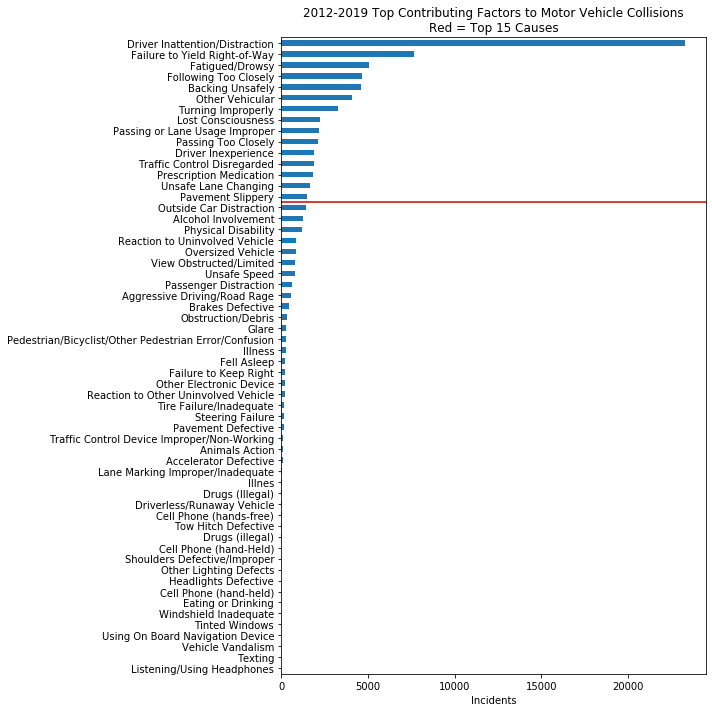

In [14]:
def plot_top_causes(data):
    d = data[(data['year']<=2012) | ((data['month'] <=3) & (data['year']==2019))]
    d = d.groupby('reason').agg({'incidents': np.sum}).sort_values(by='incidents')
    d.plot(kind='barh', legend=False, figsize=(10,10))
    plt.title('2012-2019 Top Contributing Factors to Motor Vehicle Collisions\nRed = Top 15 Causes')
    plt.xlabel('Incidents')
    plt.ylabel('')
    plt.axhline(len(d)-15.5, color='#CC0000')
    plt.tight_layout()
    plt.savefig('nypd_largest_reasons.jpg', dpi=80)

plot_top_causes(results_nypd)

In [17]:
data = results_nypd
d = data[(data['year']<=2012) | ((data['month'] <=6) & (data['year']==2019))]
d.shape

(60824, 7)

In [16]:

def combine_data(data_noaa, data_nypd):
    
    # Prepare NOAA data
    cols = ['date','day','year','month','dow','id']
    
    d_prcp = data_noaa[data_noaa['element'] == 'PRCP'].groupby(cols).agg({'value': np.sum}).reset_index().rename(columns={'value': 'PRCP'})
    d_tmax = data_noaa[data_noaa['element'] == 'TMAX'].groupby(cols).agg({'value': np.max}).reset_index().rename(columns={'value': 'TMAX'})
    d_tmin = data_noaa[data_noaa['element'] == 'TMIN'].groupby(cols).agg({'value': np.min}).reset_index().rename(columns={'value': 'TMIN'})
    d_snwd = data_noaa[data_noaa['element'] == 'SNWD'].groupby(cols).agg({'value': np.max}).reset_index().rename(columns={'value': 'SNWD'})
        
    d_noaa = d_prcp.merge(d_tmax, on=cols, how='outer')
    d_noaa = d_noaa.merge(d_tmin, on=cols, how='outer')
    d_noaa = d_noaa.merge(d_snwd, on=cols, how='outer')
    
    d_noaa = d_noaa.groupby(['date','day','year','month','dow']).agg(np.median).reset_index().fillna(0)
    d_noaa['TMAX'] = (d_noaa['TMAX'] / 10) * (9/5) + 32
    d_noaa['TMIN'] = (d_noaa['TMAX'] / 10) * (9/5) + 32
    
    # Prepare NYPD data, use top 20 reasons from prior to June 2019
    d_prior = data_nypd[(data_nypd['year']<=2016) | ((data_nypd['month'] <=3) & (data_nypd['year']==2019))]
    top_reasons = d_prior.groupby('reason').agg({'incidents': np.sum}).nlargest(20, columns='incidents').index.values
    
    d_nypd = data_nypd.copy()
    d_nypd['reason'] = d_nypd['reason'].apply(lambda x: 'Other' if x not in top_reasons else x)
    
    d_nypd = d_nypd.pivot_table(index=['day','year','month','dow'], 
                                columns='reason', values='incidents', aggfunc='sum').replace(0, np.NaN)
    d_nypd['Total'] = d_nypd.sum(axis=1)
    
    # Merge Results
    d_combined = d_nypd.reset_index().merge(d_noaa, on=['day','year','month','dow'], how='inner')
    d_combined['IsWeekend'] = d_combined['dow'].isin([1,7]).astype(int)

    return d_combined

pvt_combined = combine_data(results_noaa, results_nypd)
pvt_combined.head(5)

,day,year,month,dow,Alcohol Involvement,Backing Unsafely,Driver Inattention/Distraction,Driver Inexperience,Failure to Yield Right-of-Way,Fatigued/Drowsy,...,Traffic Control Disregarded,Turning Improperly,Unsafe Lane Changing,Total,date,PRCP,TMAX,TMIN,SNWD,IsWeekend
0,1,2012,7,1,8.0,21.0,62.0,7.0,16.0,28.0,...,8.0,11.0,NaN,233.0,2012-07-01,0.0,95.00,49.1000,0.0,1
1,1,2012,8,4,3.0,15.0,57.0,10.0,27.0,43.0,...,9.0,13.0,NaN,254.0,2012-08-01,81.0,81.05,46.5890,0.0,0
2,1,2012,9,7,6.0,12.0,52.0,7.0,20.0,25.0,...,10.0,9.0,NaN,222.0,2012-09-01,0.0,90.05,48.2090,0.0,1
3,1,2012,10,2,1.0,9.0,69.0,9.0,18.0,34.0,...,5.0,14.0,NaN,230.0,2012-10-01,0.0,71.51,44.8718,0.0,0
4,1,2012,11,5,3.0,12.0,48.0,2.0,17.0,19.0,...,4.0,9.0,1.0,186.0,2012-11-01,0.0,51.98,41.3564,0.0,0


In [89]:
cols = ['date','day','year','month','dow','id']
data_noaa = results_noaa
data_noaa[data_noaa['element'] == 'PRCP'].groupby(cols).agg({'value': np.sum}).reset_index().rename(columns={'value': 'PRCP'})


,date,day,year,month,dow,id,PRCP
0,2012-01-01,1,2012,1,1,US1NYQN0002,0.0
1,2012-01-01,1,2012,1,1,US1NYRC0002,0.0
2,2012-01-01,1,2012,1,1,US1NYWC0009,0.0
3,2012-01-01,1,2012,1,1,USC00300961,25.0
4,2012-01-01,1,2012,1,1,USW00014732,15.0
5,2012-01-01,1,2012,1,1,USW00094728,13.0
6,2012-01-01,1,2012,1,1,USW00094789,18.0
7,2012-01-02,2,2012,1,2,US1NYQN0002,10.0
8,2012-01-02,2,2012,1,2,US1NYRC0002,13.0
9,2012-01-02,2,2012,1,2,US1NYWC0009,18.0


In [2]:
from tabulate import tabulate
print(pvt_combined.shape)
 
#print(tabulate(pvt_combined, headers='keys', tablefmt='psql'))

NameError: name 'pvt_combined' is not defined

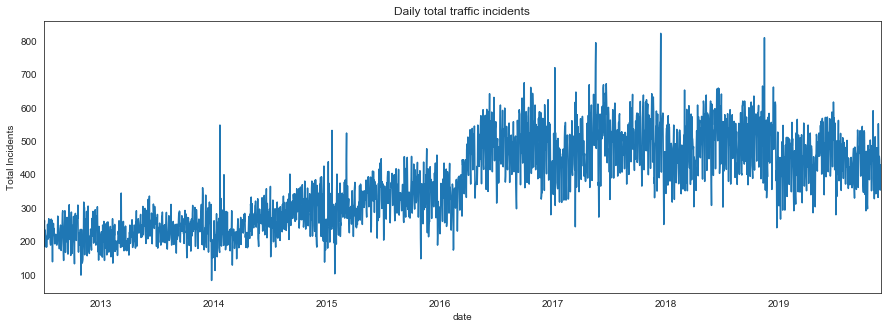

In [78]:
%matplotlib inline

pvt_combined.sort_values(by='date').set_index('date')['Total'].plot(figsize=(15,5))
plt.title('Daily total traffic incidents')
plt.ylabel('Total Incidents');
plt.savefig('nypd_daily_records.jpg', dpi=80)

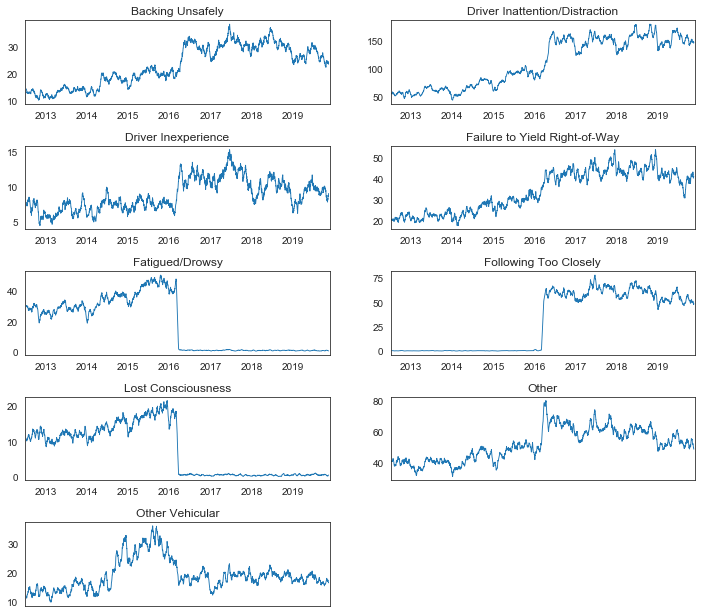

In [72]:

def plot_types(data):
    d = data[[c for c in data.columns if c not in ['day','year','month','dow','PRCP','IsWeekend',
                                                   'TMAX','TMIN','SNWD']]]
    d = d.sort_values(by='date').set_index('date').fillna(0)
    #d = d.apply(lambda x: x.rolling(center=True, window=5))
    d = d.rolling(window=21, center=True, axis=0).mean()

    fig = plt.figure(figsize=(12,20))
    l = math.ceil(len(d.columns)/2)
    for i in range(0, l):
        ax = plt.subplot(l, 2, i+1)
        d.iloc[:,i].plot(ax=ax, linewidth=0.9)
        ax.set_title(d.columns[i])
        ax.set_xlabel('')
        if i < l-2:
            ax.tick_params(labelbottom='off')
        else:
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

            
    
    plt.subplots_adjust(hspace=0.5)
    plt.savefig('nypd_daily_records_all.jpg', dpi=80)
    
plot_types(pvt_combined)

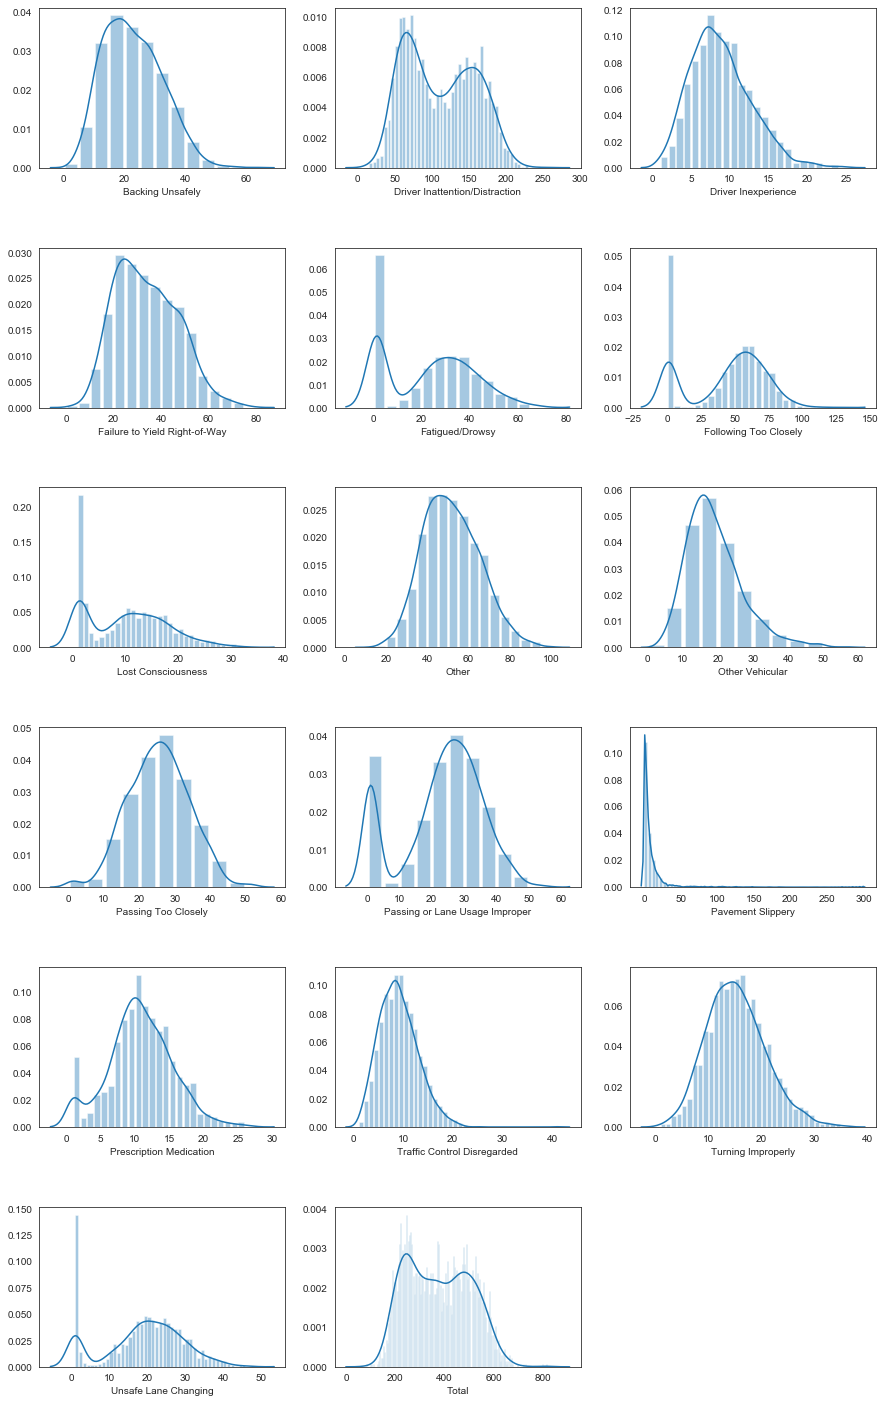

In [73]:

def plot_distributions(data):
    %matplotlib inline
    ds = data[[c for c in data.columns if c not in ['day','year','month','dow','date','TMAX','TMIN','SNWD','PRCP','IsWeekend']]]
    c = 3
    r = math.ceil(len(ds.columns) / c)
    
    sns.set_style('white')
    plt.figure(figsize=(15,25))
    for i in range(0, len(ds.columns)):
        ax = plt.subplot(r, c, i+1)
        d = ds.iloc[:, i].dropna()
        m = int(d.max())

        bins = list(range(0, m, 1 if m<50 else 5))
        sns.distplot(d, ax=ax, bins=bins, hist_kws={'rwidth': 0.8})
        
    plt.subplots_adjust(hspace=0.5)
    plt.savefig('nypd_daily_records_dist.jpg', dpi=80)
    
plot_distributions(pvt_combined)

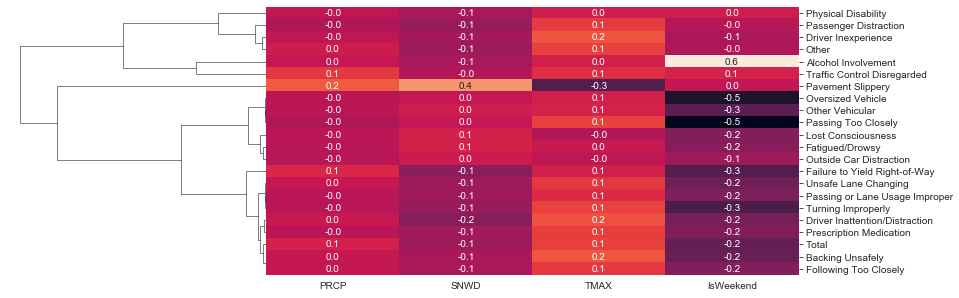

In [92]:
def plot_corr(data):
    # Columns for the heatmap
    cols = ['PRCP','SNWD','TMAX', 'IsWeekend']
    
    d= data[[c for c in data if c not in ['day','year','month','dow','TMIN']]].corr()
    d = d.loc[~d.index.isin(cols), cols] # Prevent creating a triangle effect
    
    %matplotlib inline
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    cm = sns.clustermap(d, col_cluster=False, metric='cosine', method='complete', annot=True, fmt='.1f', figsize=(12,6))
    plt.setp(cm.ax_heatmap.get_yticklabels(), rotation=0)
    
    # Some formatting to remove the column dendograms which take up space regardless. Also format the row dendograms
    cm.cax.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    hm = cm.ax_heatmap.get_position()
    cm.ax_heatmap.set_position([.3, .5, hm.width, hm.height])
    cm.ax_row_dendrogram.set_position([0, .5, .3, hm.height])
    plt.savefig('nypd_daily_records_cormap.jpg', dpi=120)
    plt.show()
    
plot_corr(pvt_combined)




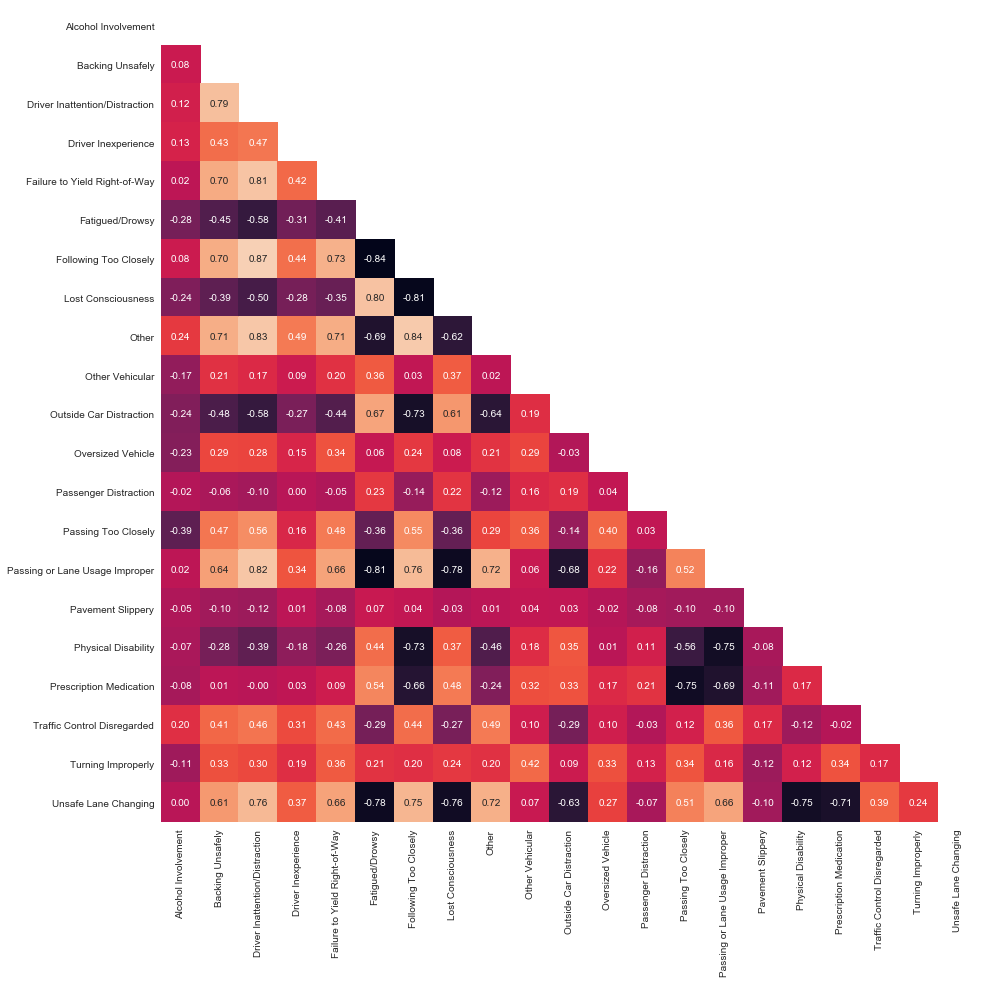

In [93]:
def plot_corr_accident(data):
    d = data[[c for c in data if c not in ['day','year','month','dow','TMIN','TMAX','PRCP','SNWD','Total','IsWeekend']]].corr()
    
    mask = np.zeros_like(d)
    mask[np.triu_indices_from(mask)] = True
    
    %matplotlib inline
    plt.figure(figsize=(15,15))
    with sns.axes_style("white"):
        sns.heatmap(d, cbar=False, square=True, annot=True, fmt='.2f', mask=mask)
        
    plt.savefig('nypd_traffic_corr.jpg', dpi=80)
    
plot_corr_accident(pvt_combined)

C:\tools\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<Figure size 432x288 with 0 Axes>

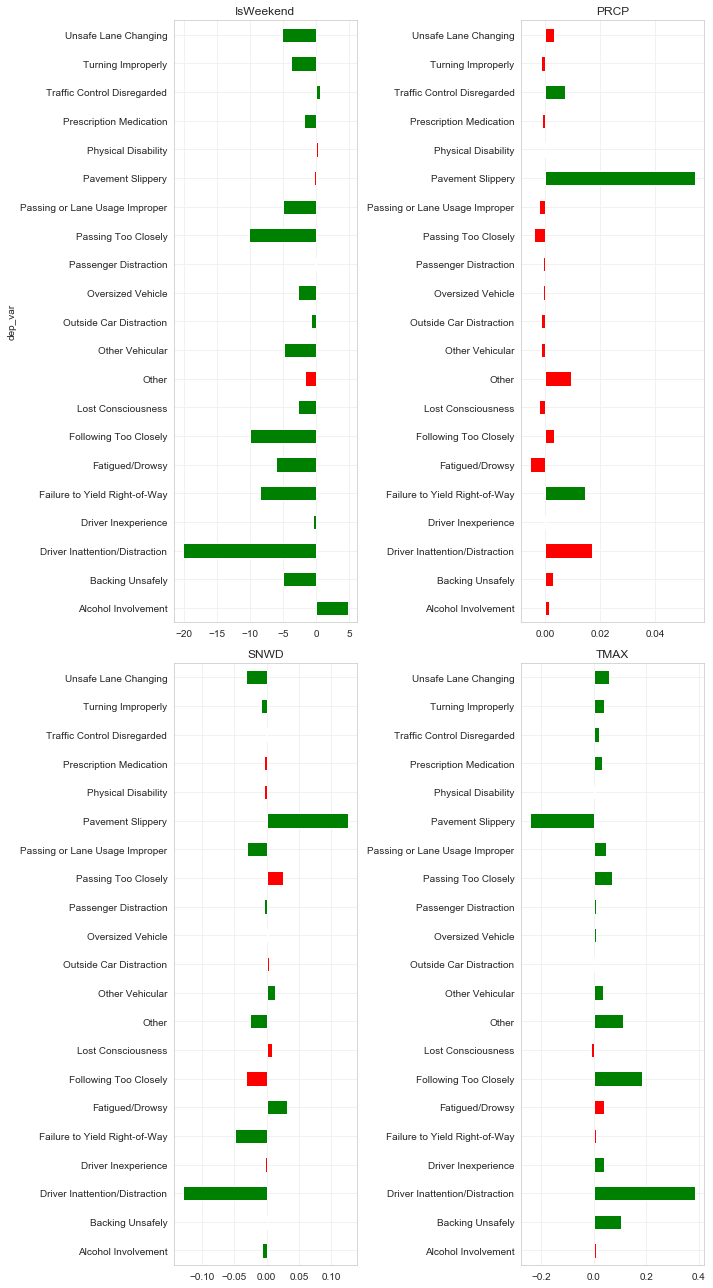

In [94]:

from statsmodels.api import OLS
import statsmodels.api as sm
from sklearn import preprocessing

def plot_regressors(data):
    d = data.copy()
    d['IsWeekend'] = d['dow'].isin([1,7]).astype(int)

    X_cols = ['TMAX','SNWD','PRCP','IsWeekend']
    y_cols = [c for c in data if c not in ['day','year','month','dow','TMIN','TMAX','SNWD','PRCP','Total','date','IsWeekend']]
    
    out = pd.DataFrame()
    for c in y_cols:
        d_filtered = d[~d[c].isnull()]
        X = d_filtered[X_cols]
        X = sm.add_constant(X)
        
        y = d_filtered[c]
        model = OLS(y, X)
        result = model.fit()
        r = result.conf_int()
        r['pa'] = result.params
        r['pv'] = result.pvalues
        r['name'] = c
        
        out = pd.concat([out, r])
        
    out = out.reset_index()   
    out.columns = ['ind_var','cl_lower','cl_upper','coef','pvalue','dep_var']
    out = out[out['ind_var']!='const']
    
    %matplotlib inline
    sns.set_style('whitegrid', {'grid.color': '#EEEEEE'})
    sns.despine()
    plt.figure(figsize=(10,18))
    i=1
    for name, group in out.groupby('ind_var'):
        ax = plt.subplot(2, 2, i)
        c = (group['pvalue']<0.01).map({True: 'green', False: 'red'})
        group.plot(x='dep_var', y='coef', kind='barh', ax=ax, title=name, legend=False, color=c)
        
        if i>1:
            1==1
            #ax.set_yticklabels([])
            #ax.yaxis.set_visible(False)
            ax.set_ylabel('')
        i += 1
    plt.subplots_adjust(wspace=0.9)
    plt.tight_layout()
    plt.savefig('nypd_traffic_reg.jpg', dpi=120)
    return out


reg = plot_regressors(pvt_combined)

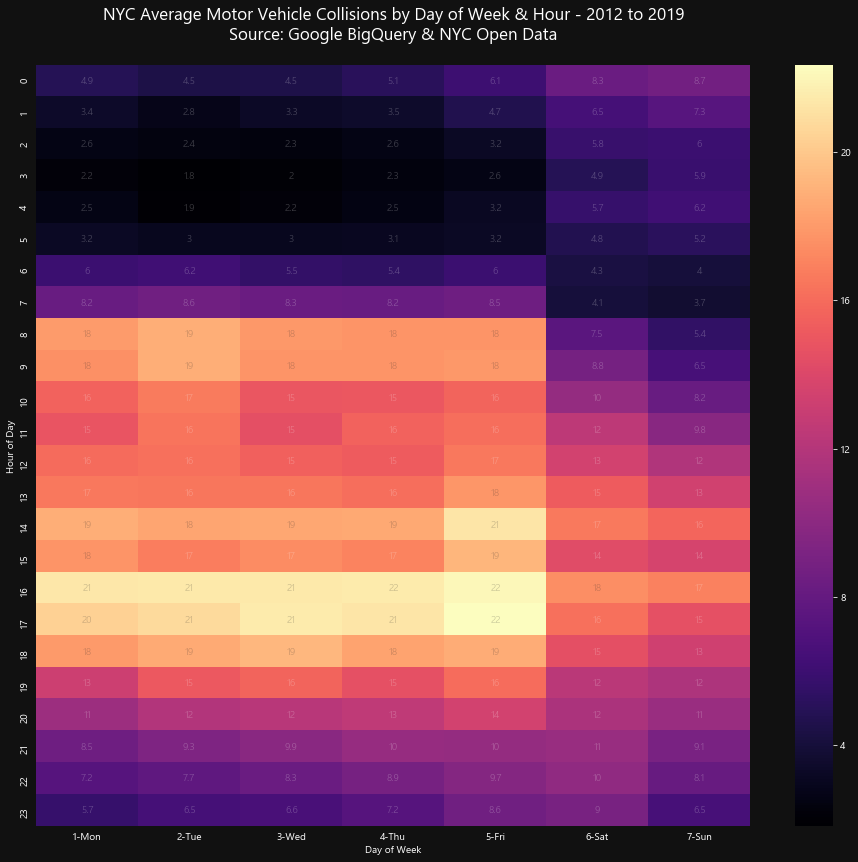

In [147]:
def plot_heatmap(data):
    d = data.copy()
    d['dow'] = d['dow'].map({1: '7-Sun', 2: '1-Mon', 3: '2-Tue', 4:'3-Wed', 5:'4-Thu', 6:'5-Fri', 7:'6-Sat'})
    d['avg'] = d['incidents'] / d['days']
    d = d.pivot(index='hour', columns='dow', values='avg')

    %matplotlib inline

    custom_style = {
        'font.family':'Segoe UI',
        'xtick.color': '#FFFFFF',
        'ytick.color': '#FFFFFF'}
    sns.set_style("darkgrid", rc=custom_style)
    fig = plt.figure(figsize=(16,14),  facecolor='#111111')
    sns.heatmap(d, cmap='magma', cbar=True, annot=True, annot_kws={'size': 10, 'alpha': 0.25, 'family': 'Segoe UI', 'weight': 'light'})
    
    plt.title('NYC Average Motor Vehicle Collisions by Day of Week & Hour - 2012 to 2019\nSource: Google BigQuery & NYC Open Data\n', 
              fontsize=17,  color='white')
    plt.xlabel("Day of Week", color='white')
    plt.ylabel("Hour of Day", color='white')
    plt.savefig('nypd-heatmap-out.png', facecolor=fig.get_facecolor(), transparent=True, dpi=150)

    
plot_heatmap(results_nypd2)